# DEPLOYMENT SYSTEM TIME SERIES

## Menggunakan Random Forest

## app.py

In [ ]:
# ==========================================================
# app.py (VERSI MODERN - TEMA BIRU)
# Sistem Prediksi NO2 berbasis Random Forest
# ==========================================================
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
import os
import model_utils as mu
from datetime import timedelta

# ==========================================================
# 0. KONFIGURASI STREAMLIT & TEMA
# ==========================================================
st.set_page_config(
    page_title="Prediksi NO₂ Harian",
    page_icon="💧",
    layout="wide"
)

# ==========================================================
# GAYA VISUAL (CSS - Tema Biru)
# ==========================================================
st.markdown("""
    <style>
    body {
        background-color: #f0f6fb;
    }
    .main-title {
        text-align: center;
        font-size: 2.3em;
        color: #1e3a8a;
        font-weight: 800;
        margin-bottom: 0.3em;
    }
    .subtitle {
        text-align: center;
        color: #2563eb;
        font-size: 1.1em;
        margin-bottom: 1.8em;
    }
    .stCard {
        background: white;
        padding: 25px;
        border-radius: 15px;
        box-shadow: 0px 2px 8px rgba(0,0,0,0.08);
        margin-bottom: 20px;
    }
    div.stButton > button:first-child {
        background-color: #2563eb;
        color: white;
        font-weight: bold;
        border-radius: 10px;
        padding: 0.6em 1.3em;
        border: none;
    }
    div.stButton > button:hover {
        background-color: #1e40af;
        color: white;
    }
    .stMetric {
        background: #e0f2fe;
        padding: 15px;
        border-radius: 10px;
    }
    hr {
        border: 1px solid #c7d2fe;
    }
    </style>
""", unsafe_allow_html=True)

# ==========================================================
# 1. HEADER
# ==========================================================
st.markdown('<h1 class="main-title">💧 Prediksi Konsentrasi NO₂ Harian</h1>', unsafe_allow_html=True)
st.markdown('<p class="subtitle">📘 Model <b>Random Forest</b> digunakan untuk memprediksi konsentrasi NO₂ berdasarkan data historis.</p>', unsafe_allow_html=True)
st.markdown("---")

# ==========================================================
# 2. KONFIGURASI & PEMUATAN MODEL
# ==========================================================
DATA_FILE = "NO2_Modo.csv"
N_LAGS = mu.N_LAGS
TEST_SIZE = mu.TEST_SIZE_DAYS

@st.cache_resource
def load_or_train_model(file_path, n_lags, test_size):
    if not os.path.exists('model'):
        os.makedirs('model')
    try:
        results = mu.prepare_and_train_all(file_path, n_lags, test_size)
        return results['rf_model'], results['full_df'], results['last_data'], results['metrics_rf']
    except Exception as e:
        st.error(f"❌ Gagal memuat atau melatih model. Error: {e}")
        return None, None, None, None

with st.spinner("🔄 Memuat & melatih model Random Forest..."):
    rf_model, full_data, last_data, metrics = load_or_train_model(DATA_FILE, N_LAGS, TEST_SIZE)

if rf_model is None:
    st.error("Model gagal dimuat. Aplikasi dihentikan.")
    st.stop()

st.success("✅ Model Random Forest berhasil dimuat dan siap digunakan!")

last_historical_date = last_data.index[-1].date()

# ==========================================================
# 3. METRIK KINERJA MODEL
# ==========================================================
st.markdown("### 📊 Evaluasi Model Random Forest")
col1, col2 = st.columns(2)

with col1:
    st.metric("🎯 MAPE", f"{metrics['mape']:.2f}%", help="Mean Absolute Percentage Error (semakin kecil semakin baik)")
with col2:
    st.metric("📈 ACF Residual (Lag 1)", f"{metrics['acf']:.4f}", help="Nilai mendekati nol menunjukkan model sudah baik")

st.markdown("---")

# ==========================================================
# 4. INPUT PERIODE PREDIKSI
# ==========================================================
st.markdown("### 🗓️ Tentukan Periode Prediksi")
col_start, col_end = st.columns([1, 2])

start_date_forecast = last_historical_date + timedelta(days=1)
with col_start:
    st.date_input("Tanggal Mulai Prediksi", value=start_date_forecast, disabled=True)
    st.markdown(f"📅 <b>Data terakhir:</b> `{last_historical_date}`", unsafe_allow_html=True)

with col_end:
    target_date = st.date_input(
        "Pilih Tanggal Akhir Prediksi",
        min_value=start_date_forecast,
        value=start_date_forecast + timedelta(days=7),
        max_value=start_date_forecast + timedelta(days=60),
        help="Maksimal 60 hari dari data historis terakhir."
    )

days_to_forecast = (target_date - last_historical_date).days
st.markdown("---")

# ==========================================================
# 5. PROSES PREDIKSI
# ==========================================================
if st.button(f"🚀 Prediksi Selama {days_to_forecast} Hari (Hingga {target_date})"):
    if days_to_forecast < 1:
        st.warning("⚠️ Pilih tanggal yang lebih besar dari data historis terakhir.")
        st.stop()

    with st.spinner("🔮 Model sedang memprediksi NO₂..."):
        forecast_df = mu.predict_rf_n_days(rf_model, last_data, days_to_forecast, N_LAGS)
        forecast_df.index = pd.to_datetime(forecast_df.index)
        forecast_df = forecast_df.sort_index()

    st.success("✅ Prediksi selesai!")

    # Tambahkan label kualitas udara
    def quality_level(no2):
        if no2 < 40:
            return "🟢 Baik"
        elif no2 < 80:
            return "🟡 Sedang"
        else:
            return "🔴 Tidak Sehat"

    forecast_df["Kualitas Udara"] = forecast_df["NO2_Prediction"].apply(quality_level)
    display_df = forecast_df[["NO2_Prediction", "Kualitas Udara"]].copy()
    display_df.index.name = "Tanggal"
    display_df.columns = ["Prediksi NO₂ (µg/m³)", "Kualitas Udara"]

    # ==========================================================
    # 6. HASIL DALAM TAB
    # ==========================================================
    tab1, tab2, tab3 = st.tabs(["📊 Grafik", "📅 Tabel", "💾 Unduh"])

    with tab1:
        st.markdown("### 📊 Grafik Prediksi NO₂")
        fig, ax = plt.subplots(figsize=(11, 5))
        ax.plot(full_data["NO2"].tail(90), label="Data Historis (90 Hari Terakhir)", color="#2563eb", linewidth=2)
        ax.axvline(x=forecast_df.index.min(), color="#475569", linestyle="--", label="Awal Prediksi")
        ax.plot(forecast_df.index, forecast_df["NO2_Prediction"], label="Prediksi NO₂", color="#1d4ed8", linewidth=2.5)
        ax.set_title(f"Prediksi Konsentrasi NO₂ Hingga {target_date}", fontsize=13, color="#1e3a8a")
        ax.set_xlabel("Tanggal"); ax.set_ylabel("Konsentrasi NO₂ (µg/m³)")
        ax.grid(alpha=0.3); ax.legend()
        plt.xticks(rotation=45)
        st.pyplot(fig)

    with tab2:
        st.markdown("### 📅 Detail Prediksi Harian")
        st.dataframe(display_df.style.format({"Prediksi NO₂ (µg/m³)": "{:.2f}"}), use_container_width=True)

    with tab3:
        st.markdown("### 💾 Unduh Hasil Prediksi")
        csv = display_df.to_csv().encode("utf-8")
        st.download_button(
            label="📥 Unduh Data (.csv)",
            data=csv,
            file_name=f"Prediksi_NO2_RF_Hingga_{target_date}.csv",
            mime="text/csv"
        )

Kode di atas digunakan untuk membuat aplikasi web prediksi konsentrasi gas NO₂ harian berbasis *machine learning* menggunakan model Random Forest, dengan tampilan antarmuka interaktif yang dibangun menggunakan Streamlit. Aplikasi ini bertujuan untuk membantu pengguna memperkirakan kadar NO₂ beberapa hari ke depan berdasarkan data historis yang tersimpan dalam file CSV.

Pada bagian awal, kode melakukan import library penting seperti `pandas` untuk pengolahan data, `matplotlib` untuk visualisasi grafik, dan `model_utils` yang berisi fungsi pendukung pelatihan serta prediksi model. Kemudian, aplikasi dikonfigurasi agar memiliki tema biru modern, lengkap dengan CSS yang mengatur tampilan tombol, teks, dan komponen visual agar terlihat lebih menarik.

Selanjutnya, aplikasi akan memuat atau melatih model Random Forest secara otomatis dengan memanggil fungsi `prepare_and_train_all()` dari `model_utils`. Jika model berhasil dimuat, sistem menampilkan metrik kinerja model seperti MAPE (Mean Absolute Percentage Error) dan nilai ACF (Autocorrelation Function), yang membantu pengguna menilai seberapa akurat model dalam melakukan prediksi.

Pengguna kemudian dapat memilih periode prediksi, yaitu berapa hari ke depan model akan memperkirakan kadar NO₂. Setelah tombol “Prediksi” ditekan, model akan menjalankan proses peramalan dengan fungsi `predict_rf_n_days()`. Hasilnya kemudian ditampilkan dalam tiga tab berbeda: grafik (menunjukkan tren historis dan hasil prediksi), tabel (berisi nilai prediksi serta kategori kualitas udara seperti “Baik”, “Sedang”, atau “Tidak Sehat”), dan fitur unduhan CSV agar pengguna bisa menyimpan hasil prediksi ke komputer.

Secara keseluruhan, kode ini berfungsi sebagai sistem prediksi dan visualisasi kualitas udara interaktif, yang tidak hanya menampilkan hasil numerik, tapi juga memberikan konteks visual dan evaluasi performa model dengan antarmuka profesional dan mudah digunakan.


## model_utils.py



In [ ]:
# model_utils.py
import pandas as pd
import numpy as np
import joblib
import os
from datetime import timedelta
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.stattools import acf

# --- KONFIGURASI GLOBAL ---
N_LAGS = 7  # Jumlah hari sebelumnya (lags) yang digunakan sebagai fitur
TEST_SIZE_DAYS = 90 # Jumlah hari untuk data uji
MODEL_PATH = 'model/rf_model.pkl'
Z_SCORE = 1.96 # Faktor Z-score untuk 95% Confidence Interval

# ----------------------------------------------------
# A. FUNGSI UMUM DATA PRE-PROCESSING
# ----------------------------------------------------

def load_and_clean_data(file_path):
    """Memuat dan membersihkan data NO2."""
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File data tidak ditemukan: {file_path}")

    df = pd.read_csv(file_path)
    df['time'] = pd.to_datetime(df['time'])
    df = df.set_index('time')
    # Mengisi nilai hilang (missing values) dengan forward fill
    df['NO2'] = df['NO2'].fillna(method='ffill')
    return df

def create_lags(data, n_lags):
    """Membuat fitur lagged dari data deret waktu."""
    df_lags = pd.DataFrame(data['NO2'])
    for i in range(1, n_lags + 1):
        df_lags[f'NO2_Lag_{i}'] = df_lags['NO2'].shift(i)
    df_lags.dropna(inplace=True)
    return df_lags.drop('NO2', axis=1), df_lags['NO2']

def split_data(X, y, test_size_days):
    """Membagi data latih dan uji secara kronologis."""
    return X.iloc[:-test_size_days], X.iloc[-test_size_days:], \
           y.iloc[:-test_size_days], y.iloc[-test_size_days:]

def get_last_data(df, n_lags):
    """Mengambil N_LAGS data historis terakhir."""
    return df['NO2'].tail(n_lags)

# ----------------------------------------------------
# B. FUNGSI RANDOM FOREST (RF)
# ----------------------------------------------------

def train_rf(X_train, y_train):
    """Melatih Random Forest."""
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf_model.fit(X_train, y_train)
    joblib.dump(rf_model, MODEL_PATH)
    return rf_model

def predict_rf_n_days(model, last_data_series, n_days, n_lags):
    """Prediksi RF multi-step rekursif dengan Confidence Interval 95%."""
    if model is None or len(last_data_series) != n_lags:
        return pd.DataFrame()

    current_features = last_data_series.values
    predictions_data = []
    last_date = last_data_series.index[-1]

    for _ in range(n_days):
        X_input = current_features.reshape(1, -1)

        # 1. Prediksi dari setiap pohon (untuk CI)
        all_tree_preds = [tree.predict(X_input)[0] for tree in model.estimators_]

        # 2. Hitung Statistik
        mean_prediction = np.mean(all_tree_preds)
        std_prediction = np.std(all_tree_preds)

        # 3. Hitung Batas 95% CI
        lower_bound = mean_prediction - Z_SCORE * std_prediction
        upper_bound = mean_prediction + Z_SCORE * std_prediction

        predictions_data.append({
            'NO2_Prediction': mean_prediction,
            'Lower_Bound': lower_bound,
            'Upper_Bound': upper_bound
        })

        # 4. Update fitur rekursif (gunakan mean_prediction sebagai Lag_1 hari berikutnya)
        current_features = np.roll(current_features, 1)
        current_features[0] = mean_prediction

    forecast_dates = pd.date_range(start=last_date + timedelta(days=1), periods=n_days, freq='D')
    return pd.DataFrame(predictions_data, index=forecast_dates)

# ----------------------------------------------------
# C. FUNGSI UTAMA (TRAINING & LOADING)
# ----------------------------------------------------

def prepare_and_train_all(file_path, n_lags, test_size_days):
    """Fungsi utama untuk melatih RF dan evaluasi."""
    df = load_and_clean_data(file_path)

    # --- RF Training ---
    X_rf, y_rf = create_lags(df, n_lags)
    X_train_rf, X_test_rf, y_train_rf, y_test_rf = split_data(X_rf, y_rf, test_size_days)
    rf_model = train_rf(X_train_rf, y_train_rf)

    # Evaluasi metrik
    y_pred_rf = rf_model.predict(X_test_rf)
    mape_rf = mean_absolute_percentage_error(y_test_rf, y_pred_rf) * 100
    acf_rf = acf(y_test_rf - y_pred_rf, nlags=1, fft=True)[1]

    # Hasil
    last_data = get_last_data(df, n_lags)

    return {
        'rf_model': rf_model,
        'full_df': df,
        'last_data': last_data,
        'metrics_rf': {'mape': mape_rf, 'acf': acf_rf},
    }

def load_rf_model():
    """Memuat model RF yang sudah disimpan."""
    try:
        rf_model = joblib.load(MODEL_PATH)
        return rf_model
    except FileNotFoundError:
        return None

Kode `model_utils.py` ini berfungsi sebagai modul utama untuk sistem prediksi kadar NO₂ harian menggunakan metode Random Forest Regression. Tujuan utamanya adalah membangun seluruh proses mulai dari pembersihan data, pelatihan model, hingga prediksi multi-hari ke depan dengan hasil yang memiliki tingkat kepercayaan (confidence interval). Pertama, bagian konfigurasi global menetapkan parameter penting seperti jumlah hari yang dijadikan lag (`N_LAGS`), jumlah hari data uji (`TEST_SIZE_DAYS`), lokasi penyimpanan model (`MODEL_PATH`), dan nilai Z-score untuk menghitung interval kepercayaan. Selanjutnya, bagian data preprocessing bertugas untuk memuat dan membersihkan data dari file CSV, mengubah kolom waktu menjadi format datetime, mengisi nilai yang hilang, membuat fitur lag dari data historis, serta membagi data menjadi bagian latih dan uji secara kronologis.

Setelah data siap, bagian Random Forest Functions digunakan untuk melatih model dan melakukan prediksi. Fungsi `train_rf()` akan melatih model Random Forest Regressor menggunakan data latih dan menyimpannya dalam bentuk file `.pkl`. Sementara itu, fungsi `predict_rf_n_days()` digunakan untuk melakukan prediksi kadar NO₂ beberapa hari ke depan secara rekursif, yaitu menggunakan hasil prediksi hari sebelumnya sebagai input untuk hari berikutnya. Selain menghasilkan nilai prediksi rata-rata, fungsi ini juga menghitung batas bawah dan atas dari Confidence Interval 95% berdasarkan variasi antar pohon dalam model Random Forest.

Terakhir, bagian fungsi utama menyediakan `prepare_and_train_all()` untuk melatih model secara menyeluruh, mengevaluasi performanya menggunakan metrik MAPE (Mean Absolute Percentage Error) dan ACF (autokorelasi residual), serta menyiapkan data historis terakhir sebagai dasar prediksi ke depan. Fungsi `load_rf_model()` juga disediakan agar model yang sudah pernah dilatih bisa dimuat kembali tanpa perlu dilatih ulang setiap kali aplikasi dijalankan. Secara keseluruhan, kode ini berperan penting sebagai fondasi dari aplikasi prediksi kualitas udara berbasis NO₂, karena mengelola seluruh proses mulai dari persiapan data hingga menghasilkan prediksi multi-hari yang siap ditampilkan pada antarmuka aplikasi seperti Streamlit.


## Link Deploy


https://time-series-modo-herlynabila.streamlit.app/

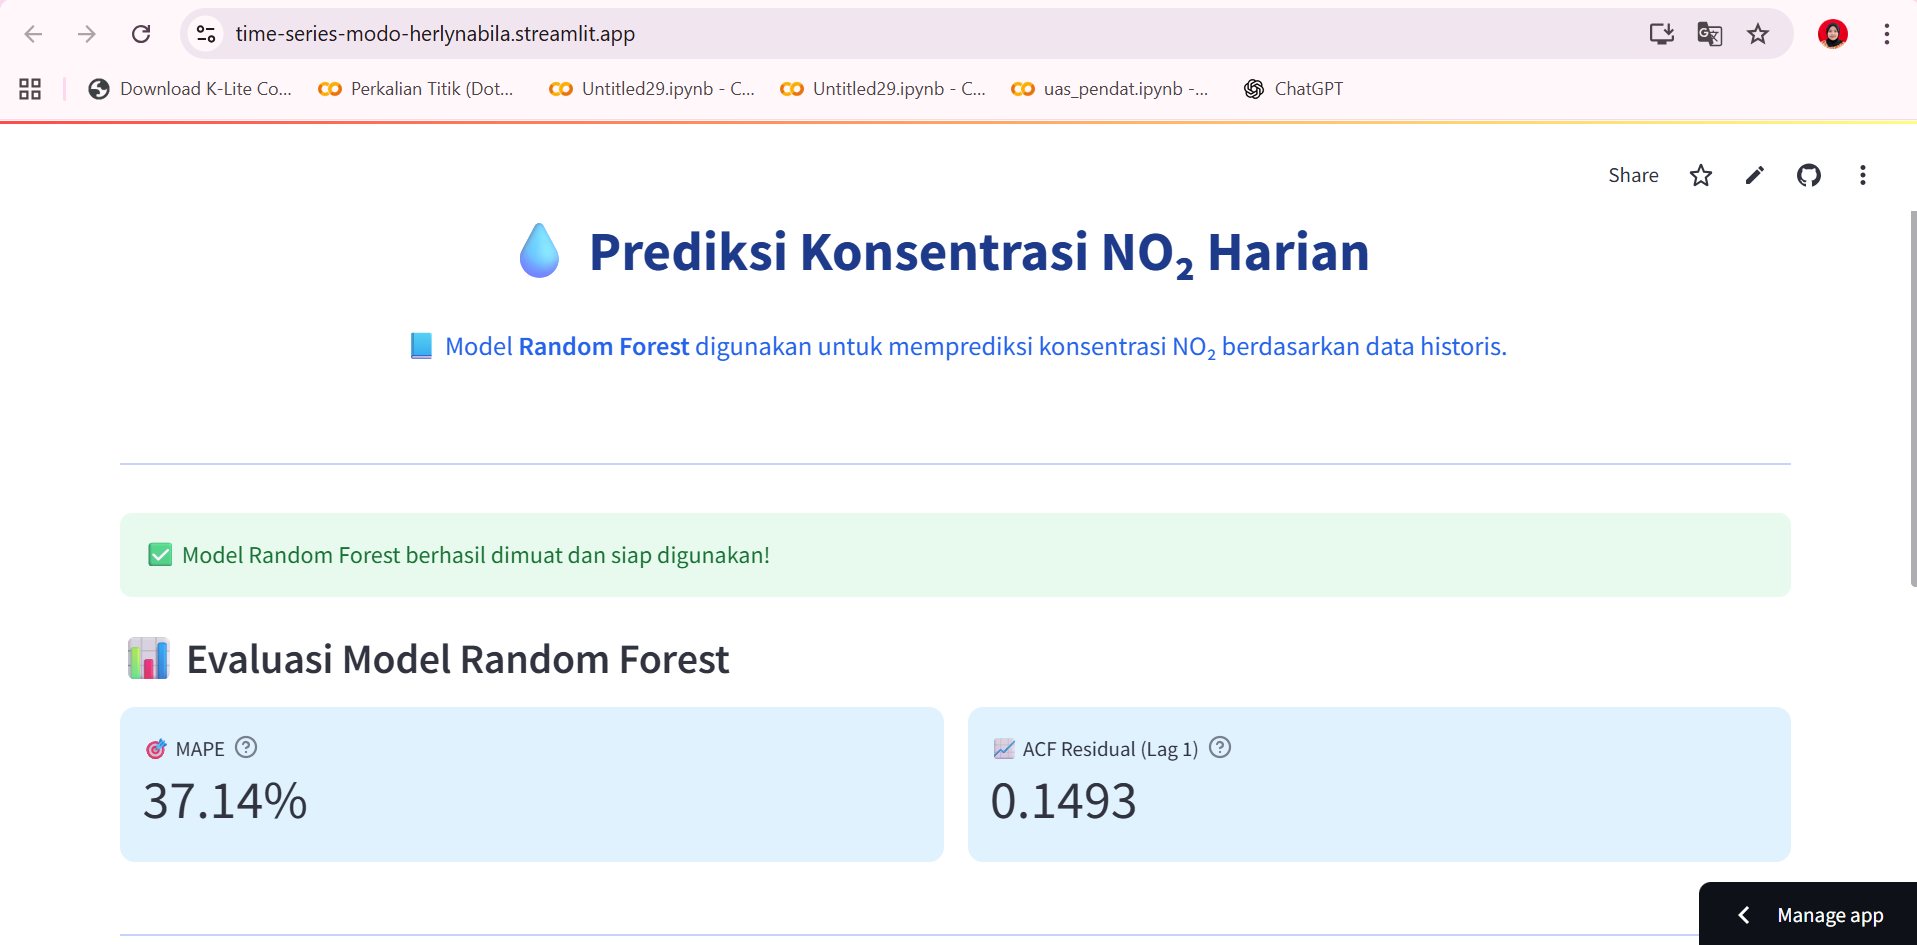